# Lab 4: Working with Large Data Sources in S3

Today we're going to be working with two large public datasets that are hosted in S3: the [NYC Taxi dataset](https://registry.opendata.aws/nyc-tlc-trip-records-pds/) and [GDELT](https://registry.opendata.aws/gdelt/). We could theoretically download this data and work with it locally, but it is enormous and it is not practical to query and subset it on a local machine. It makes sense to work with the data in the AWS cloud, where it already lives. To this end, we will use Python's `boto3` library to run AWS Athena and S3 Select resources. With these resources, we can begin to access and understand these large datasets in a serverless capacity, without needing to set up database servers. We'll explore further methods for analyzing and fitting models on large-scale data in Weeks 7 and 8 when we learn more about Spark, but this should whet your appetite and help you see how you can use `boto3` to do large-scale cloud computing tasks within a Jupyter notebook.

If you haven't already, please install the `boto3` package (via Anaconda, this can be achieved by running `conda install boto3` on the command line). The package will allow you to work with AWS resources using the credentials you have provided as a part of your AWS CLI configuration. So, you should confirm that these credentials are correct (recall that your AWS Educate session token changes every 3 hours) in order to ensure the code runs.

In [1]:
import boto3
import time
import pandas as pd

First, let's initialize our S3 resource via Boto3.

In [2]:
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

And we can identify data that fits particular criteria within an S3 bucket by cycling through all the objects within the bucket. Here, we identify files that record Yellow Cab data from 2019:

In [10]:
bucket = 'nyc-tlc'
bucket_resource = s3_resource.Bucket(bucket)
[obj.key for obj in bucket_resource.objects.all() if '2019' in obj.key and 'yellow' in obj.key]

['trip data/yellow_tripdata_2019-01.csv',
 'trip data/yellow_tripdata_2019-02.csv',
 'trip data/yellow_tripdata_2019-03.csv',
 'trip data/yellow_tripdata_2019-04.csv',
 'trip data/yellow_tripdata_2019-05.csv',
 'trip data/yellow_tripdata_2019-06.csv',
 'trip data/yellow_tripdata_2019-07.csv',
 'trip data/yellow_tripdata_2019-08.csv',
 'trip data/yellow_tripdata_2019-09.csv',
 'trip data/yellow_tripdata_2019-10.csv',
 'trip data/yellow_tripdata_2019-11.csv',
 'trip data/yellow_tripdata_2019-12.csv']

So, we seem to have a number of CSV files that fit this criteria. How do we actually see what's inside these files and begin to analyze it? First of all, we could assess the general content of a file by previewing the file. For instance, we could generate a url for the file in S3 and read only a subset of the CSV's rows into a Pandas DataFrame. You'll notice, though, that this takes a while to run (20 seconds for only 10 rows!). This strategy will not scale up very well for downloading large amounts of data locally.

In [11]:
def s3_csv_preview(bucket, key, rows=10):
    '''
    Preview CSV in S3 Bucket as Pandas DataFrame
    '''
    data_source = {
            'Bucket': bucket,
            'Key': key
    }

    url = s3.generate_presigned_url(
              ClientMethod = 'get_object',
              Params = data_source
    )

    data = pd.read_csv(url, nrows=rows)
    return data
t0 = time.time()
df = s3_csv_preview(bucket='nyc-tlc', key='trip data/yellow_tripdata_2019-12.csv', rows=10)
print(time.time()-t0, 'seconds')

df.head()

19.907142639160156 seconds


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1,4.2,1,N,142,116,2,14.5,3.0,0.5,0.0,0,0.3,18.3,2.5
1,1,2019-12-01 00:12:08,2019-12-01 00:12:14,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0,0.3,3.8,0.0
2,1,2019-12-01 00:25:53,2019-12-01 00:26:04,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0,0.3,3.8,0.0
3,1,2019-12-01 00:12:03,2019-12-01 00:33:19,2,9.4,1,N,138,25,1,28.5,0.5,0.5,10.0,0,0.3,39.8,0.0
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2,1.6,1,N,161,237,2,9.0,3.0,0.5,0.0,0,0.3,12.8,2.5


Alternatively, we might use S3 Select (via Boto3) to gather only a subset of the data that meets the criteria we're interested in. S3 Select is a serverless approach, which effectively spins up compute cores for us, searches for particular criteria in parallel, and then returns the results of the search to our local machine.

As a demonstration, let's select 100 passenger_count and trip_distance datapoints, where the number of passengers in the cab was greater than 3. 

You'll notice that S3 Select uses SQL syntax to specify this subset of data. If you don't already know SQL, don't worry about it for this class. I would recommend, though, that you eventually learn (at a least a bit of) SQL, as this is the standard language for any database querying (as well as serverless database querying in AWS). If you're interested, you can [learn the basics in a couple of hours on DataCamp](https://learn.datacamp.com/courses/introduction-to-sql).

If we run our S3 Select query and save the result into a DataFrame, we can see that it took a lot less time to use S3 Select than our preview function above.

In [159]:
def s3_select(Bucket, Key, Expression):
    import io

    s3_select_results = s3.select_object_content(
        Bucket=Bucket,
        Key=Key,
        Expression=Expression,
        ExpressionType='SQL',
        InputSerialization={'CSV': {"FileHeaderInfo": "Use"}},
        OutputSerialization={'JSON': {}},
    )
    
    df = pd.DataFrame()
    for event in s3_select_results['Payload']:
        if 'Records' in event:
            df = pd.read_json(io.StringIO(event['Records']['Payload'].decode('utf-8')), lines=True)
    return df

t0 = time.time()
df = s3_select(Bucket = 'nyc-tlc', Key = 'trip data/yellow_tripdata_2019-12.csv',
                                             Expression = '''
                                             select passenger_count, trip_distance
                                             from s3object s
                                             where s.passenger_count > '3'
                                             limit 100
                                             '''
)
print(time.time()-t0, 'seconds')
df

0.2540404796600342 seconds


,passenger_count,trip_distance
0,5,19.98
1,4,0.80
2,4,2.60
3,4,0.90
4,5,16.53
...,...,...
95,5,0.63
96,5,6.27
97,6,0.92
98,5,1.21


Then, with this subset of data, we can use our standard Pandas tools to calculate summary statistics and make plots.

In [160]:
(df.groupby('passenger_count')
   .describe()
)

trip_distance                                                 \
                        count      mean       std   min    25%    50%    75%   
passenger_count                                                                
4                        39.0  4.234103  4.863248  0.00  0.850  2.180  6.180   
5                        40.0  3.459500  3.934379  0.16  1.515  2.085  4.255   
6                        21.0  1.957143  1.187287  0.74  1.070  1.640  2.570   

                        
                   max  
passenger_count         
4                21.00  
5                19.98  
6                 5.37

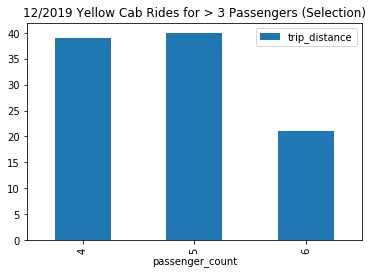

In [162]:
(df.groupby('passenger_count').count()
                              .plot
                              .bar(legend=True, title='12/2019 Yellow Cab Rides for > 3 Passengers (Selection)')
);

One limitation to S3 Select, though, is that it can only search over and return a limited amount of data at one time. If you have larger queries you would like to perform (i.e. over many gigabytes or terabytes of data) on data in an S3 bucket, it would be better to use AWS Athena, which you can also access via the Boto3 Python package. Athena additionally allows you to run queries over all of the available files in the bucket being queried (for instance, over all of the Yellow Cab CSV files in the NYC Taxi Bucket).

The only catch with Athena is that, before you can run any queries, you will need to specify your data schema -- how your data is structured and the data types that are used -- so that it knows how to read the data. After you have specified this information, Athena can run standard SQL queries in a serverless fashion. Alternatively, you can also use AWS Glue crawlers to discover the schematization for you if you want to abstract the process even further. We will not be using AWS Glue today, though, and will just manually specify the schema of our data (typically, this is already by defined for AWS' public datasets and does not require too much effort).

Let's transition over to another large public dataset on AWS for our work with Athena -- the Global Database of Events, Language and Tone (GDELT) Project. The project "monitors the world’s broadcast, print, and web news from nearly every corner of every country in over 100 languages and identifies the people, locations, organizations, counts, themes, sources, emotions, quotes, images and events driving our global society every second of every day" ([Registry of Open Data on AWS](https://registry.opendata.aws/gdelt/)).

First, let's specify a function to run an Athena query using Boto3. Then, we'll establish our data's schema using the `create_db` and `create_table` queries. From here, we should be ready to begin learning more about the data itself in the GDELT bucket!

In [129]:
#Function for starting athena query
def run_query(query, database, s3_output):
    client = boto3.client('athena')
    response = client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
            },
        ResultConfiguration={
            'OutputLocation': s3_output,
            }
        )
    print('Execution ID: ' + response['QueryExecutionId'])
    
    # Wait until query is done running to return response
    running = True
    while running:
        execution = client.get_query_execution(QueryExecutionId=res['QueryExecutionId'])
        execution_status = execution["QueryExecution"]["Status"]["State"]
        if execution_status == 'QUEUED' or execution_status == 'RUNNING':
            pass
        else:
            running = False
            print('QUERY', execution_status)
    
    return response

# Athena saves the results of each query to an S3 bucket, so we need to specify this bucket:
s3_output = 's3://jclindaniel-athena/'

create_db = 'CREATE DATABASE IF NOT EXISTS gdelt;'
create_table = \
"""
CREATE EXTERNAL TABLE IF NOT EXISTS gdelt.events (`globaleventid` INT,`day` INT,`monthyear` INT,`year` INT,`fractiondate` FLOAT,`actor1code` string,`actor1name` string,`actor1countrycode` string,`actor1knowngroupcode` string,`actor1ethniccode` string,`actor1religion1code` string,`actor1religion2code` string,`actor1type1code` string,`actor1type2code` string,`actor1type3code` string,`actor2code` string,`actor2name` string,`actor2countrycode` string,`actor2knowngroupcode` string,`actor2ethniccode` string,`actor2religion1code` string,`actor2religion2code` string,`actor2type1code` string,`actor2type2code` string,`actor2type3code` string,`isrootevent` BOOLEAN,`eventcode` string,`eventbasecode` string,`eventrootcode` string,`quadclass` INT,`goldsteinscale` FLOAT,`nummentions` INT,`numsources` INT,`numarticles` INT,`avgtone` FLOAT,`actor1geo_type` INT,`actor1geo_fullname` string,`actor1geo_countrycode` string,`actor1geo_adm1code` string,`actor1geo_lat` FLOAT,`actor1geo_long` FLOAT,`actor1geo_featureid` INT,`actor2geo_type` INT,`actor2geo_fullname` string,`actor2geo_countrycode` string,`actor2geo_adm1code` string,`actor2geo_lat` FLOAT,`actor2geo_long` FLOAT,`actor2geo_featureid` INT,`actiongeo_type` INT,`actiongeo_fullname` string,`actiongeo_countrycode` string,`actiongeo_adm1code` string,`actiongeo_lat` FLOAT,`actiongeo_long` FLOAT,`actiongeo_featureid` INT,`dateadded` INT,`sourceurl` string) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe' WITH SERDEPROPERTIES ('serialization.format' = '\t','field.delim' = '\t') LOCATION 's3://gdelt-open-data/events/';
"""

queries = [create_db, create_table]

for q in queries:
    print("Executing query: %s" % (q))
    res = run_query(q, 'gdelt', s3_output)

Executing query: CREATE DATABASE IF NOT EXISTS gdelt;
Execution ID: 93719594-85a6-404c-86e6-31581ff128b5
Executing query: 
CREATE EXTERNAL TABLE IF NOT EXISTS gdelt.events (`globaleventid` INT,`day` INT,`monthyear` INT,`year` INT,`fractiondate` FLOAT,`actor1code` string,`actor1name` string,`actor1countrycode` string,`actor1knowngroupcode` string,`actor1ethniccode` string,`actor1religion1code` string,`actor1religion2code` string,`actor1type1code` string,`actor1type2code` string,`actor1type3code` string,`actor2code` string,`actor2name` string,`actor2countrycode` string,`actor2knowngroupcode` string,`actor2ethniccode` string,`actor2religion1code` string,`actor2religion2code` string,`actor2type1code` string,`actor2type2code` string,`actor2type3code` string,`isrootevent` BOOLEAN,`eventcode` string,`eventbasecode` string,`eventrootcode` string,`quadclass` INT,`goldsteinscale` FLOAT,`nummentions` INT,`numsources` INT,`numarticles` INT,`avgtone` FLOAT,`actor1geo_type` INT,`actor1geo_fullname` 

OK, let's actually run some queries on the data in the bucket. First of all, how many events are recorded in the dataset?

**Important Note: Only run the following queries once (or not at all). Athena charges by the amount of data you query (~200 GB for this dataset), and you will quickly be out of AWS Educate credits if you run these too many times.**

In [130]:
query = '''
        SELECT COUNT(*) as nb_events
        FROM gdelt.events;
        '''
res = run_query(query, 'gdelt', s3_output)

Execution ID: 32f20018-1970-41c8-924d-07958732d6e4


In [140]:
s3_csv_preview(bucket='jclindaniel-athena', key=res['QueryExecutionId']+'.csv')

,nb_events
0,596867240


We can also select subset of our data for further analysis. Here, we count the number of events that occur each year in the dataset and plot those values once we have this subset of the data back on our local machine.

In [35]:
query = '''
        SELECT year,
        COUNT(globaleventid) AS nb_events
        FROM gdelt.events
        GROUP BY year
        ORDER BY year ASC;
        '''
res = run_query(query, 'gdelt', s3_output)

Execution ID: a6b82630-bfaf-460b-abf7-4aa318d6649b


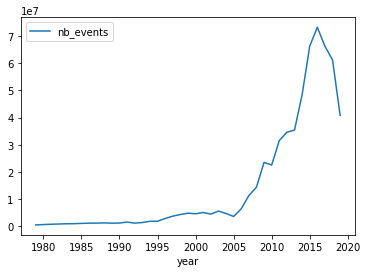

In [50]:
df = s3_csv_preview(bucket='jclindaniel-athena', key=res['QueryExecutionId']+'.csv', rows=100)
df.plot('year', 'nb_events');

We can also, of course, write even more complicated queries, such as this one where we identify the number of events that involved "Barack Obama" as an actor. 

In [286]:
query = '''
        SELECT year, COUNT(globaleventid) AS nb_events
        FROM gdelt.events
        WHERE actor1name='BARACK OBAMA'
        GROUP BY year
        ORDER BY year ASC;
        '''
res = run_query(query, 'gdelt', s3_output)

Execution ID: 98cf1be1-176a-4e3d-b2b8-da17011b8e80


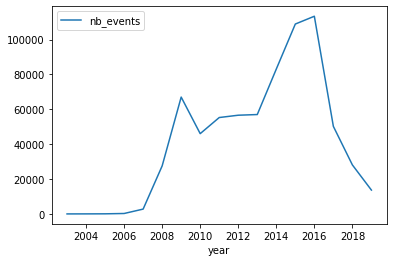

In [291]:
df = s3_csv_preview(bucket='jclindaniel-athena', key=res['QueryExecutionId']+'.csv', rows=100)
df.plot('year', 'nb_events')

If you run all of these queries, you'll notice that the number of files in your S3 bucket piles pretty quickly:

In [204]:
bucket = 'jclindaniel-athena'
bucket_resource = s3_resource.Bucket(bucket)
[obj.key for obj in bucket_resource.objects.all()]

['0a36b310-9887-4b37-847d-e64989bc3983.txt',
 '153a8b81-6e98-460a-9253-c6068668458e.csv',
 '153a8b81-6e98-460a-9253-c6068668458e.csv.metadata',
 '33139b47-ed3f-41ee-b168-448a225e8571.txt',
 '51268bcc-828d-4f7a-8eec-95da4ec0d451.txt',
 '6cd95e26-c6b8-4cf9-b3e9-978d6c6379bb.txt',
 '6da6d823-f215-4fc4-b8f3-2b3cd8f04f49.txt',
 '83ed475d-2fc0-468d-92fb-40609d33067d.txt',
 '8f248d44-bcee-4526-8022-456e4cd28138.csv',
 '8f248d44-bcee-4526-8022-456e4cd28138.csv.metadata',
 '9a057580-a6db-496b-ac1c-00f4b9a576f2.txt',
 '9a524817-3adf-4bd1-b696-fe6009d2bd62.csv',
 '9a524817-3adf-4bd1-b696-fe6009d2bd62.csv.metadata',
 '9b3f3e97-20c6-4274-a8fb-6d232c6cee2d.txt',
 'b39cd5bb-3c07-4252-9f70-724101e4cea2.txt',
 'f388b614-9b93-4952-853b-3be7818fdccd.csv',
 'f388b614-9b93-4952-853b-3be7818fdccd.csv.metadata']

You can quickly delete all of the files in your bucket (so that you don't have to pay for them) by running the following `cleanup` function:

In [294]:
def cleanup(bucket_name):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    for item in bucket.objects.all():
        item.delete()
        
cleanup('jclindaniel-athena')